# gpOptimizer Single-Task Test

This is the new test for fvgp version 4.0.0 and later.

In [ ]:
##first install the newest version of fvgp
#!pip install gpcam==?.?.?

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

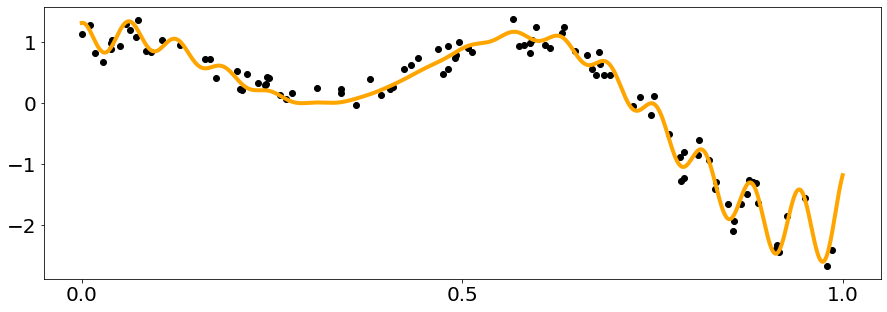

In [3]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(100) 
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')

## Customizing a Gaussian Process

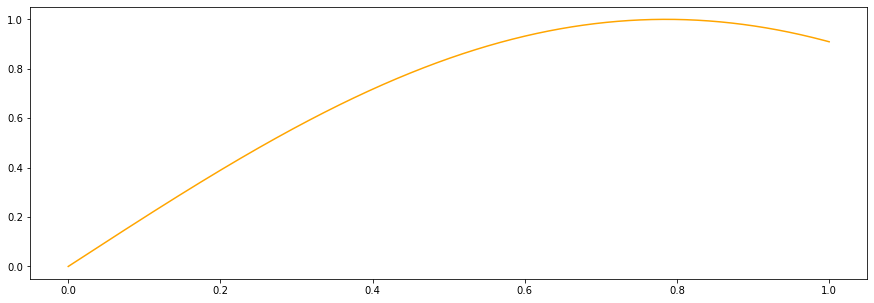

In [4]:
def my_noise(x,hps,obj):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
def skernel(x1,x2,hps,obj):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])


def meanf(x, hps, obj):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.]), None), color = 'orange', label = 'task1')

## Initialization and different training options

In [5]:
my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])

my_gpo.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gpo.train(hps_bounds)
print("Global Training")
my_gpo.train(hps_bounds, method='global')
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hps_bounds, method='local')
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gpo.train(hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [3.24257761 0.5220547  0.05414044 0.01002458]
Local Training
[3.24258334 0.52199668 0.05410253 0.01002456]
MCMC Training
HGDL Training


### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [ ]:
opt_obj = my_gpo.train_async(hps_bounds)

In [ ]:
for i in range(10):
    time.sleep(5)
    my_gpo.update_hyperparameters(opt_obj)
    print(my_gpo.hyperparameters)
    print("")

In [ ]:
my_gpo.stop_training(opt_obj)

## The Result

46.48492246495863
-0.14411592132448844


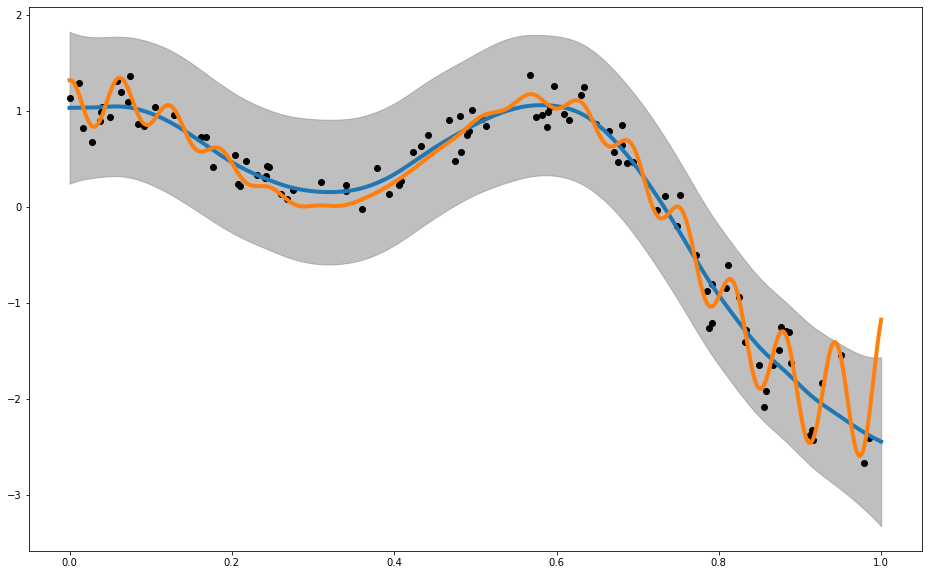

In [6]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

And just for fun, we can plot how much information we are predicted to gain if we measured points across the domain

expected_improvement None
PI None
[2.73199923e-003 2.29705236e-003 1.91882028e-003 1.59232345e-003
 1.31260527e-003 1.07480399e-003 8.74217804e-004 7.06362150e-004
 5.67017800e-004 4.52268615e-004 3.58528424e-004 2.82556946e-004
 2.21465032e-004 1.72707754e-004 1.34074355e-004 1.03672188e-004
 7.99014706e-005 6.14265158e-005 4.71435165e-005 3.61474772e-005
 2.77113697e-005 2.12578928e-005 1.63322671e-005 1.25788606e-005
 9.72144259e-006 7.54676197e-006 5.89108128e-006 4.62927808e-006
 3.66611260e-006 2.92887882e-006 2.36229230e-006 1.92493854e-006
 1.58580769e-006 1.32165342e-006 1.11502158e-006 9.52782229e-007
 8.25038652e-007 7.24317421e-007 6.44967526e-007 5.82667249e-007
 5.34005970e-007 4.96285285e-007 4.67415611e-007 4.45818712e-007
 4.30302695e-007 4.19967565e-007 4.14135912e-007 4.12301780e-007
 4.14092802e-007 4.19242043e-007 4.27566847e-007 4.38917788e-007
 4.53115684e-007 4.70001799e-007 4.89436863e-007 5.11291908e-007
 5.35441083e-007 5.61756126e-007 5.90102227e-007 6.20332

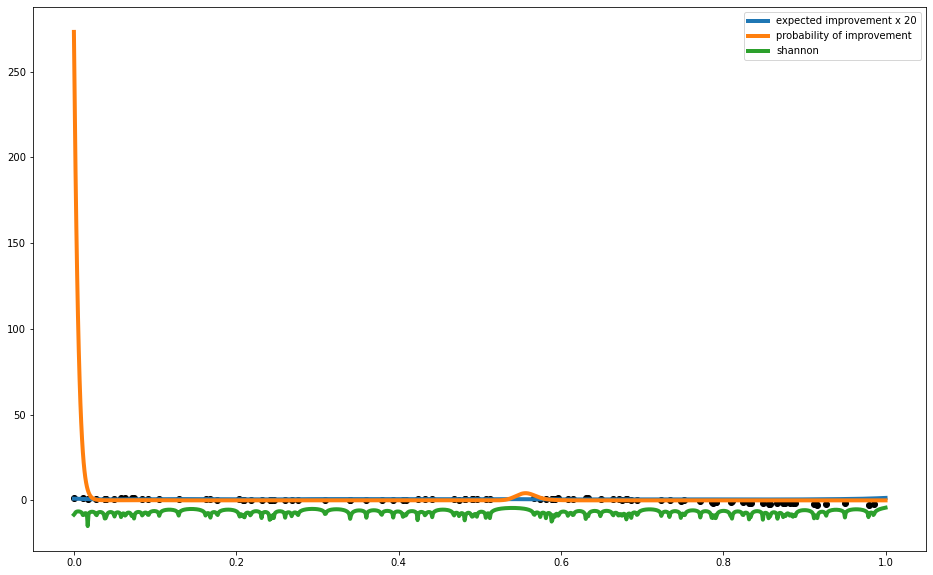

In [52]:
sig3 =  my_gpo.shannon_information_gain_vec(x_pred.reshape(-1,1))["sig(x)"]
ex_improv = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function="expected_improvement")
prob_improv = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function="PI")
print(prob_improv)
plt.figure(figsize = (16,10))
plt.plot(x_pred,ex_improv * 20.0, label = "expected improvement x 20", linewidth = 4)
plt.plot(x_pred,prob_improv * 1e5, label = "probability of improvement", linewidth = 4)
plt.plot(x_pred,sig3, label = "shannon", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

## Now let's see what the next best point to measure is

In [30]:
bounds = np.array([[0.2,0.6]])
a = {'last best': np.max(y_data)}
my_gpo.ask(bounds, acquisition_function='expected improvement', args=a, info=True)

expected improvement {'last best': 1.3788163214387794}
[7.00205819e-06 1.52225223e-39 1.19248871e-19 3.17962935e-39
 1.98439218e-36 7.12539872e-05 5.74565697e-38 6.73929094e-54
 1.21110470e-10 2.70116084e-20 8.96755172e-16 4.88804450e-39
 1.89243615e-05 1.50164956e-37 7.23943126e-52 1.53394910e-04
 1.12002815e-36 1.50598838e-31 4.93757939e-25 7.32592405e-50]
[1.43561906e-06 1.13808071e-40 1.27646537e-20 2.38703358e-40
 1.54691232e-37 1.62933573e-05 4.38555623e-39 4.30545799e-55
 1.79016856e-11 2.84338910e-21 1.07632425e-16 3.67851384e-40
 4.05396978e-06 1.15265226e-38 4.71587328e-53 3.65839283e-05
 8.70087077e-38 1.26342881e-32 4.66408310e-26 4.86855946e-51]
expected improvement {'last best': 1.3788163214387794}
[1.49655952e-04 9.39552251e-39 2.29008893e-34 2.06791745e-05
 2.32841677e-16 4.30421705e-16 7.77915735e-06 7.15010399e-07
 2.98059159e-15 9.02523255e-37 9.99171482e-29 1.77580000e-06
 1.04365892e-36 1.27888735e-08 1.63702011e-04 5.74063576e-21
 7.78029441e-38 9.22679838e-39 1.5

{'x': array([[0.55581015]]), 'f(x)': array([-8.28181775e-07]), 'opt_obj': None}